In [2]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from skimage.filters import unsharp_mask
from natsort import natsorted
from skimage.exposure import match_histograms
# from sklearn.mixture import GaussianMixture
from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
# from statsmodels.tsa.stattools import acf
import pickle
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
# from skimage.feature import SIFT, match_descriptors,plot_matches
# from skimage.feature import ORB
import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from scipy.optimize import dual_annealing,fmin_powell
from scipy import optimize
import pickle
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread
import sys
from util_funcs import *
import h5py

In [3]:
path = f'scan1/'
pic_paths = os.listdir(path)
# for i in os.listdir(path):
#     if i.endswith('.hdf5'):
#         pic_paths.append(i)
with h5py.File(path+pic_paths[0], 'r') as hf:
    original_data = np.array(hf['volume'])

# # Creating empty array for the data
# original_data = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
# for i,j in tqdm(enumerate(pic_paths)):
#     original_data[i] = dicom.dcmread(path+j).pixel_array

# Using float32 data
# original_data = original_data.astype(np.float64)

In [4]:
original_data = original_data[:,200:600,:]

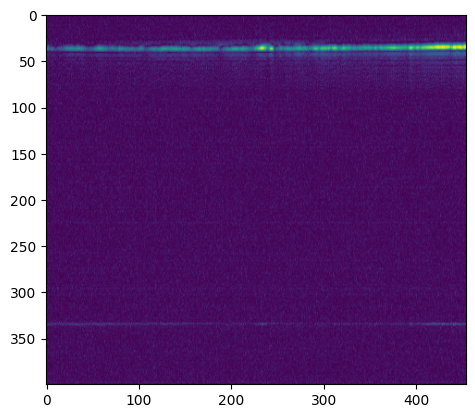

In [5]:
plt.imshow(original_data[0])

In [6]:
mid = find_mid(original_data)
n = original_data.shape[1]

# finding the bright points in all images in standard interference
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]

# intial correcting the y-motion
tf_all_nn = np.tile(np.eye(3),(original_data.shape[0],1,1))
for i in range(tf_all_nn.shape[0]):
    tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

# finding the bright points in all images to crop the standard interference
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]
UP, DOWN = np.min(nn)-80,np.max(nn)+80
UP = UP if UP>0 else 0
DOWN = DOWN if DOWN<original_data.shape[1] else original_data.shape[1]

print(UP,DOWN)

# better correcting the y-motion using functions
tr_all = ants_all_trans(original_data,UP,DOWN) # fucntion definition in util_funcs.py
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)



warping: 100%|██████████| 500/500 [00:02<00:00, 176.73it/s]


0 117


warping: 100%|██████████| 500/500 [00:02<00:00, 190.48it/s]


In [7]:
y_corrected_data = original_data.copy()
UP,DOWN = 20,55
mir_UP,mir_DOWN = 0,1

# test

In [ ]:
from smm import SMM
from skimage import exposure
from skimage.exposure import match_histograms

In [ ]:
stat = y_corrected_data[23][np.r_[mir_UP:mir_DOWN]]
mov = y_corrected_data[24][np.r_[mir_UP:mir_DOWN]]
# mov = match_histograms(mov,stat)

In [ ]:
stat_smm = SMM(n_components=3).fit(stat.reshape(-1,1))
mov_smm = SMM(n_components=3).fit(mov.reshape(-1,1))

/Users/akapatil/opt/anaconda3/envs/ImageProc_2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/akapatil/opt/anaconda3/envs/ImageProc_2/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
stat_smm.means, mov_smm.means

(array([[10.13900584],
        [24.42346716],
        [86.48180081]]),
 array([[ 12.44118566],
        [101.0375242 ],
        [ 30.13757794]]))

In [ ]:
101-86

15

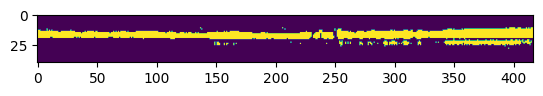

In [ ]:
plt.imshow(stat_smm.predict(stat.reshape(-1,1)).reshape(mov.shape)==2)

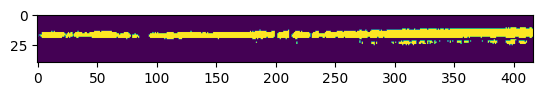

In [ ]:
plt.imshow(mov_smm.predict(mov.reshape(-1,1)).reshape(mov.shape)==1)

In [ ]:
for i in range(0,y_corrected_data.shape[0],2):
    y_corrected_data[i] = warp(y_corrected_data[i],AffineTransform(translation=(-38,0)),order=3)

new_y_corrected_data = np.empty((y_corrected_data.shape[0],y_corrected_data.shape[1],y_corrected_data.shape[2]-38))

for i in range(0,y_corrected_data.shape[0]):
    new_y_corrected_data[i] = y_corrected_data[i][:,38:]

y_corrected_data = new_y_corrected_data


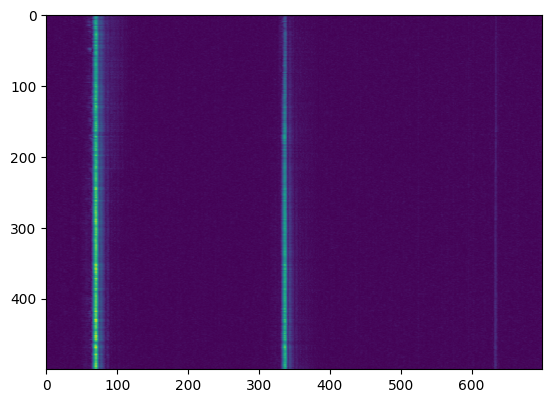

In [ ]:
plt.imshow(original_data[:,:,100])

# continue

In [ ]:
y_corrected_data = scp.median_filter(y_corrected_data,size=3)

# for i in range(y_corrected_data.shape[0]):
#     y_corrected_data[i] = scp.median_filter(y_corrected_data[i],size=3)

In [ ]:
# # y_corrected_data = original_data[5:].copy()
# UP,DOWN = 0,1
# mir_UP,mir_DOWN = 320,360

In [ ]:
def ants_reg_mapping(stat,mov):
    static = ants.from_numpy(stat.astype(np.float32))
    moving = ants.from_numpy(mov.astype(np.float32))
    reg = ants_register(static,moving,type_of_transform = 'Translation',
                        grad_step=0.1,aff_sampling=500,aff_random_sampling_rate=0.9,)
    return reg['fwdtransforms']

In [ ]:
def crop_img(shift_value, x,y):
    try:
        if shift_value >= 0:
            crop_margin = int(np.abs(shift_value)) + 1  # Add a small margin to ensure no padding
            cropped_x = x[:, :-crop_margin]
            cropped_y = y[:, :-crop_margin]
            return cropped_x, cropped_y
        else:
            crop_margin = int(np.abs(shift_value)) + 1  # Add a small margin to ensure no padding
            cropped_x = x[:, crop_margin:]
            cropped_y = y[:, crop_margin:]
            return cropped_x, cropped_y
    except:
        print(shift_value,'error')
        return x,y


def mse_fun_tran(shif,x,y):
    # tform = AffineTransform(translation=(shif[0],0))
    warped_x_stat = warp(x, AffineTransform(translation=(-shif[0],0)) ,order=3)
    warped_y_mov = warp(y, AffineTransform(translation=(shif[0],0)) ,order=3)

    # cropped_x,cropped_y = crop_img(shif[0],warped_x_stat,warped_y_mov)
    return 2-nmi(warped_x_stat ,warped_y_mov,bins=500)

# UP,DOWN = 0,1
# mir_UP,mir_DOWN = 320,360

transforms_all = np.tile(np.eye(3),(y_corrected_data.shape[0],1,1))
cols = y_corrected_data[0].shape[1]

for i in tqdm(range(3,y_corrected_data.shape[0]-1)):
    temp_tform_manual = AffineTransform(translation=(0,0))
    static = (min_max((y_corrected_data[i][np.r_[UP:DOWN,mir_UP:mir_DOWN]]))).copy()
    temp_moving = (min_max((y_corrected_data[i+1][np.r_[UP:DOWN,mir_UP:mir_DOWN]]))).copy()

    temp_moving = match_histograms(temp_moving,static)

    # row_num = np.argmax(np.sum(static,axis=1))
    # li_patch = np.argmin(static[row_num,40:-40])+40
    # static = static[:,li_patch-40:li_patch+40]
    # temp_moving = temp_moving[:,li_patch-40:li_patch+40]

    # static = static[:,210:280]
    # temp_moving = temp_moving[:,210:280]

    # static = unsharp_mask(static, radius=2, amount=2)
    # temp_moving = unsharp_mask(temp_moving, radius=2, amount=2)
    # print(static.shape, temp_moving.shape , li_patch)
    
    # temp_transform = 0
    # for _ in range(50):
    #     move = phase_cross_correlation(static,temp_moving,upsample_factor=1,normalization=None,disambiguate=True)[0][1]
    #     if np.abs(move)<2:
    #         temp_moving = warp(temp_moving, AffineTransform(translation=(-move,0)),order=0)
    #         temp_transform+=move
    #     # temp_tform_manual = np.dot(temp_tform_manual,temp_transform.params)
    # transforms_all[i+1:] = np.dot(transforms_all[i+1:],AffineTransform(translation=(-temp_transform,0)).params)

    # temp_tform_manual = AffineTransform(translation=(0,0))
    # # for _ in range(1):
    # move = dual_annealing(func = mse_fun_tran, bounds=[(-30,30)],
    #         args = (static
    #                 ,temp_moving))['x']
    # # move = minz(method='powell',fun = mse_fun_tran,x0 =(0),
    # #             args = (static
    # #                     ,temp_moving))['x']
    # temp_transform = AffineTransform(translation=(move[0]*2,0))
    # # static = warp(static, AffineTransform(translation=(-move[0],0)),order=3)
    # # temp_moving = warp(temp_moving, AffineTransform(translation=(move[0],0)),order=3)
    # temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
    # # static,temp_moving = crop_img(move[0],static,temp_moving)

    for __ in range(5):
        move = minz(method='powell',fun = mse_fun_tran,x0 =(0),bounds = ([(-3,3)]),
                args = (static
                        ,temp_moving))['x']
        # print(static.max())
        if abs(move[0])<2:
            temp_transform = AffineTransform(translation=(move[0]*2,0))
            static = warp(static, AffineTransform(translation=(-move[0],0)),order=3)
            temp_moving = warp(temp_moving, AffineTransform(translation=(move[0],0)),order=3)
            temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
        # static,temp_moving = crop_img(move[0],static,temp_moving)
    transforms_all[i+1:] = np.dot(transforms_all[i+1:],temp_tform_manual)

    # mat = scipy.io.loadmat(ants_reg_mapping(static
    #                                         ,temp_moving)[0])
    # # print(mat['AffineTransform_float_2_2'][-2:])
    # tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))
    # transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)




100%|██████████| 496/496 [09:49<00:00,  1.19s/it]


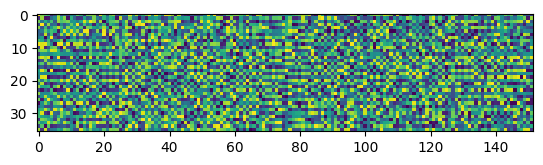

In [ ]:
# static = equalize_adapthist(min_max(y_corrected_data[0][np.r_[UP:DOWN,mir_UP:mir_DOWN]])).copy()
# temp_moving = equalize_adapthist(min_max(y_corrected_data[1][np.r_[UP:DOWN,mir_UP:mir_DOWN]])).copy()

# a = warp(static,AffineTransform(translation=(-19,0)),order=3)
# b = warp(temp_moving,AffineTransform(translation=(19,0)),order=3)

# crop_margin = int(np.abs(19)) + 1  # Add a small margin to ensure no padding
# a = a[:, crop_margin:-crop_margin]
# b = b[:, crop_margin:-crop_margin]

# np.abs(fft2(static))

plt.imshow(np.angle(fftshift(fft2(static))))

In [ ]:
from skimage.exposure import match_histograms
img1 = min_max(y_corrected_data[40,UP:DOWN,:])
img2 = min_max(y_corrected_data[41,UP:DOWN,:])
img2 = match_histograms(img2,img1)

In [ ]:
from skimage.feature import SIFT, match_descriptors, plot_matched_features

detector_extractor1 = SIFT()
detector_extractor2 = SIFT()
detector_extractor1.detect_and_extract(img1)
detector_extractor2.detect_and_extract(img2)
matches = match_descriptors(detector_extractor1.descriptors,
                            detector_extractor2.descriptors,
                            max_ratio=0.6)


In [ ]:
mv = []
for i,j in matches[:10]:
    mv.append(detector_extractor1.positions[i][1]-detector_extractor2.positions[j][1])
np.median(mv)

-0.5960286133724253

In [ ]:
matches[:10]

array([[ 6,  6],
       [37, 50],
       [43, 43],
       [51, 51],
       [61, 58],
       [64, 65],
       [66, 73],
       [69, 72],
       [75, 77],
       [76, 78]])

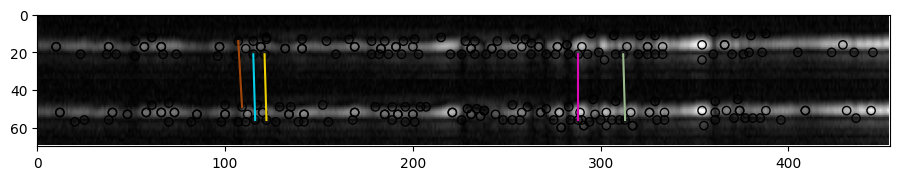

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))

plt.gray()

plot_matched_features(
    img1,
    img2,
    keypoints0=detector_extractor1.keypoints,
    keypoints1=detector_extractor2.keypoints,
    matches=matches[:5],
    ax=ax,
    alignment='vertical',
)

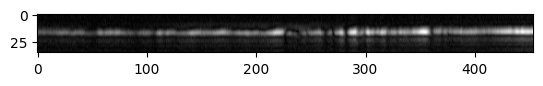

In [ ]:
plt.imshow(y_corrected_data[41,UP:DOWN,:])

In [ ]:
k = 0
for _ in range(150):
    mv = phase_cross_correlation(tp_stat,temp_movvv,upsample_factor=200,normalization='phase',disambiguate=True)[0][1]
    temp_movvv = warp(temp_movvv,AffineTransform(translation=(-mv,0)),order=3)
    # tp_stat = warp(tp_stat,AffineTransform(translation=(mv/2,0)),order=3)
    k+=mv

k

0.38

In [ ]:
med = scp.median_filter(y_corrected_data,size=3)

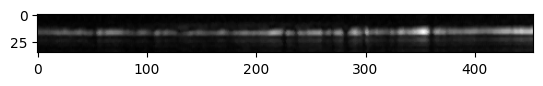

In [ ]:
plt.imshow(scp.median_filter(y_corrected_data[42,UP:DOWN,:],size=3))

In [ ]:
med.shape

(500, 35, 454)

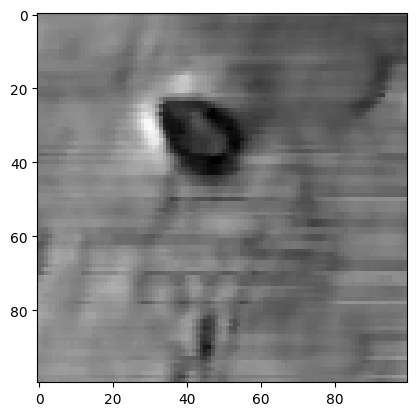

In [ ]:
plt.imshow(med[:,17,:][200:300,200:300])

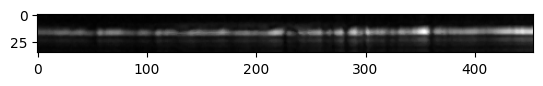

In [ ]:
plt.imshow(med[42])

In [ ]:
from skimage.metrics import structural_similarity as ssim

In [ ]:
# def mse_fun_tran(shif,x,y):
#     print(shif[0])
#     # tform = AffineTransform(translation=(shif[0],0))
#     # warped_x_stat = warp(x, AffineTransform(translation=(-shif[0],0)) ,order=3)
#     warped_y_mov = warp(y, AffineTransform(translation=(shif[0],0)) ,order=3)
#     # warped = fourier_shift(y, (0,shif[0]))
#     if shif[0] > 0:
#         return 2-nmi(x[:,:shif[0]],warped_y_mov[:,:shif[0]])
#     else:
#         return 2-nmi(x[:,-shif[0]:],warped_y_mov[:,-shif[0]:])

# fmin_powell(func = mse_fun_tran,x0=-40, ftol = 0,xtol = 0,
#                args = (y_corrected_data[20][np.r_[UP:DOWN,mir_UP:mir_DOWN]]
#                         ,y_corrected_data[21][np.r_[UP:DOWN,mir_UP:mir_DOWN]]))

# # dual_annealing(func = mse_fun_tran, bounds=[(-50,50)],
# #                args = (y_corrected_data[22][np.r_[UP:DOWN,mir_UP:mir_DOWN]]
# #                         ,y_corrected_data[23][np.r_[UP:DOWN,mir_UP:mir_DOWN]]))

In [ ]:
nmi(y_corrected_data[20],y_corrected_data[21])

1.0908401328782695

In [ ]:
np.argmax(np.sum(min_max(y_corrected_data[1][UP:DOWN]),axis=1))

17

In [ ]:
(np.argmin(min_max(y_corrected_data[1][UP:DOWN])[row_num]))

0

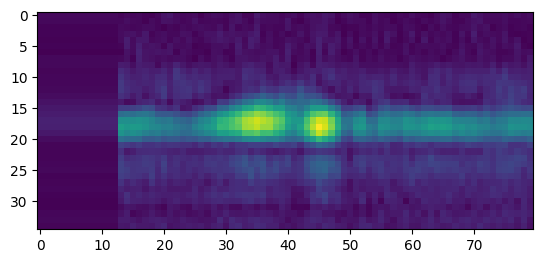

In [ ]:
plt.imshow(min_max(y_corrected_data[1][UP:DOWN][:,238-40:238+40]))

In [ ]:
fmin_powell(func = mse_fun_tran,x0=-20, ftol = 1e-13,xtol = 1e-13,
               args = (y_corrected_data[20]
                        ,y_corrected_data[21]))

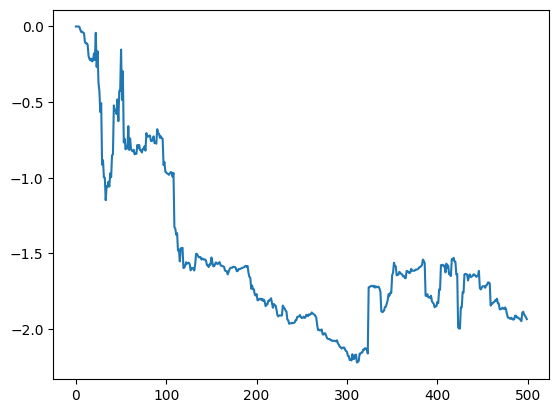

In [ ]:
plt.plot(transforms_all[:,0,2])

In [ ]:
# UP,DOWN = 50,100
# mir_UP,mir_DOWN = 300,380

# transforms_all = np.tile(np.eye(3),(y_corrected_data.shape[0],1,1))

# for i in tqdm(range(y_corrected_data.shape[0]-1)):
#     static = y_corrected_data[i][np.r_[UP:DOWN,mir_UP:mir_DOWN]]
#     temp_moving = y_corrected_data[i+1][np.r_[UP:DOWN,mir_UP:mir_DOWN]]
#     coords = phase_cross_correlation(static
#                                 ,temp_moving
#                                 ,normalization=None,upsample_factor=20)[0]
#     # temp_img = warp(temp_img,AffineTransform(translation = (-coords[0],0)),order=3)
#     print(coords)
#     tff = AffineTransform(translation = (-coords[1],0))
#     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)





In [ ]:
len(kk)

499

In [ ]:

for i in tqdm(range(y_corrected_data.shape[0])):
    y_corrected_data[i] = warp(original_data[i],AffineTransform(matrix=transforms_all[i]),order=3)

# for i in tqdm(range(1,y_corrected_data.shape[0])):
#     y_corrected_data[i] = warp(y_corrected_data[i],AffineTransform(translation=(-kk[i][0],0)),order=3)

  0%|          | 0/500 [00:00<?, ?it/s]


NameError: name 'transforms_all' is not defined

In [54]:
temp_img = y_corrected_data[:,45,:].copy()
# temp_img = med[:,45,:].copy()

# temp_img_med = scp.median_filter(temp_img,size=3)

tp = fft2(temp_img).flatten()
tp[tp.shape[0]//2:] = 0
tp = np.where(np.abs(tp)>0.25,tp,0)
temp_img = ifft2(tp.reshape(temp_img.shape)).real

In [55]:
def shift_func(shif, x, y , past_shift):
    x = scp.shift(x, -past_shift,order=1)
    y = scp.shift(y, past_shift,order=1)

    warped_x_stat = scp.shift(x, -shif[0],order=1)
    warped_y_mov = scp.shift(y, shif[0],order=1)

    return (1-ncc(warped_x_stat ,warped_y_mov))

def denoise_signal(errs , rows = 10):
    kk = fft(errs)
    kk[rows:] = 0
    kk = abs(ifft(kk))
    return kk

In [56]:
kk = []
for i in tqdm(range(temp_img.shape[0]-1)):
        st = denoise_signal(temp_img[i],rows=50)
        # mv = match_histograms(scp.median_filter(temp_img[i+1],size=3),st)
        mv = denoise_signal(temp_img[i+1],rows=50)
        rt = 0
        past_shift = 0
        # rt = phase_cross_correlation(st,mv,upsample_factor=100,disambiguate=True)[0][0]
        for _ in range(10):
                move = minz(method='powell',fun = shift_func,x0 =(0),bounds = ([(-2,2)]),
                        args = (st
                                ,mv
                                ,past_shift))['x']

                past_shift += move

                # st = scp.shift(st,-move,order=3)
                # print(mv.min())
                # mv = scp.shift(mv,move,order=3)

                # if abs(move)<=2:
                rt+=move
        kk.append(rt*2)

100%|██████████| 499/499 [01:08<00:00,  7.30it/s]


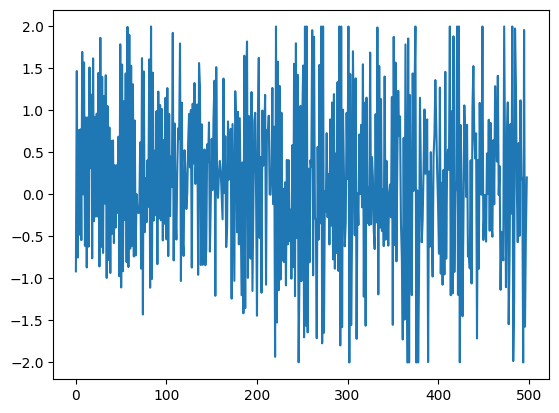

In [57]:
plt.plot(kk)

In [59]:
temp_img = y_corrected_data[:,45,:].copy()
for i in range(len(kk)):
    temp_img[i+1] = scp.shift(temp_img[i+1],kk[i])

In [47]:
# plt.plot(match_histograms(y_corrected_data[210:260,45,210:280][21],y_corrected_data[210:260,45,210:280][20]))

In [48]:
# phase_cross_correlation(y_corrected_data[210:260,45,210:280][20],y_corrected_data[210:260,45,210:280][21],upsample_factor=200)

In [60]:
# tp = fft2(temp_img).flatten()
# tp[tp.shape[0]//2:] = 0
# tp = np.where(np.abs(tp)>0.25,tp,0)
# tp = ifft2(tp.reshape(temp_img.shape)).real

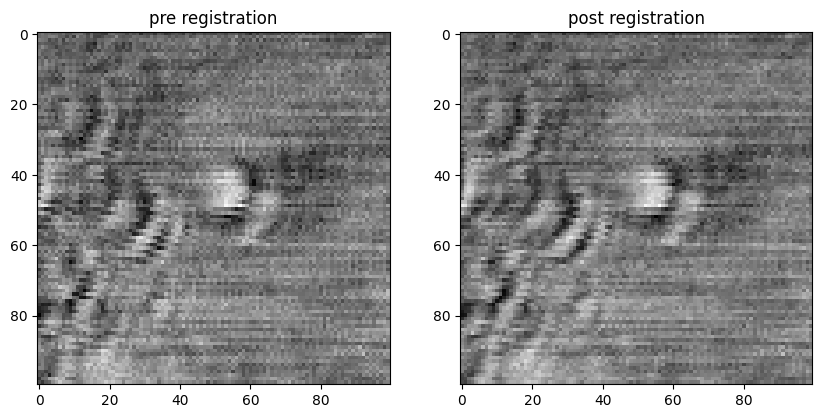

In [64]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('pre registration')
plt.imshow(y_corrected_data[:,45,:][0:100,300:400],cmap='gray')

plt.subplot(1,2,2)
plt.title('post registration')
plt.imshow(temp_img[0:100,300:400],cmap='gray')

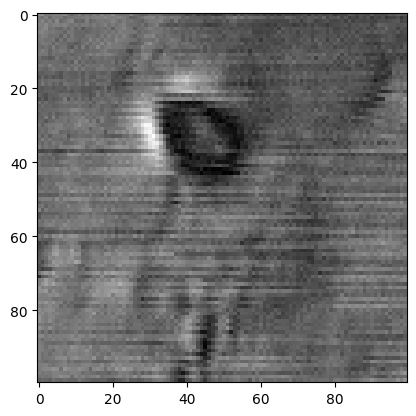

In [33]:
plt.imshow(y_corrected_data[:,45,:][200:300,200:300],cmap='gray')

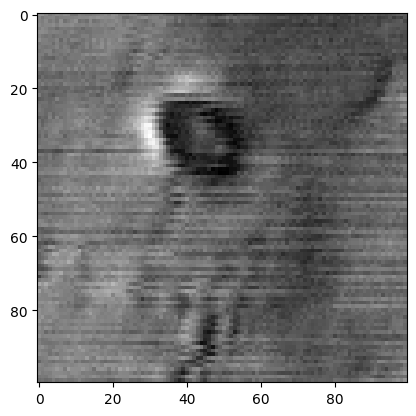

In [32]:
plt.imshow(temp_img[200:300,200:300],cmap='gray')

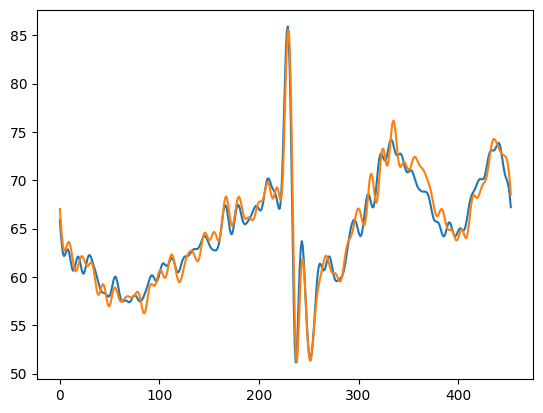

In [202]:
# plt.imshow(y_corrected_data[:,45,:])
plt.plot(denoise_signal(tp[230],rows=50))
plt.plot(denoise_signal(tp[231],rows=50))

In [260]:
init=0
for _ in range(5):
        move = minz(method='powell',fun = shift_func,x0 =(1),bounds = ([(-2,2)]),
                                args = (denoise_signal(tp[230],rows=50)
                                        ,denoise_signal(tp[231],rows=50)))['x']
        print(move*2)

[-0.85177996]
[-0.85177996]
[-0.85177996]
[-0.85177996]
[-0.85177996]


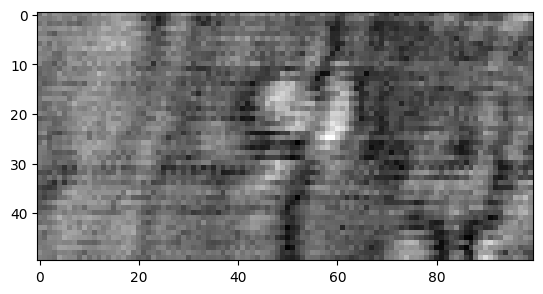

In [278]:
# plt.imshow(y_corrected_data[210:260,45,210:280])
plt.imshow(temp_img[50:100,200:300],cmap='gray')

In [279]:
for i in range(len(kk)):
    y_corrected_data[i+1] = scp.shift(y_corrected_data[i+1],shift = (0,kk[i][0]),order=3)

In [ ]:
# os.makedirs(f'test/',exist_ok=True)
# for i,j in tqdm(enumerate(y_corrected_data)):
#     # cv2.imwrite(f'test/'+f'frame_test{i}.PNG',(min_max(j)*((2**16)-1)).astype(np.uint16))
#     cv2.imwrite(f'test/'+f'frame_test{i}.PNG',j)

500it [00:00, 509.28it/s]


In [586]:
scan_num = 'scan16'

In [280]:
# os.makedirs(f'registered/{scan_num}',exist_ok=True)
for i,j in tqdm(enumerate(y_corrected_data)):
    # cv2.imwrite(f'test/'+f'frame_test{i}.PNG',(min_max(j)*((2**16)-1)).astype(np.uint16))
    cv2.imwrite(f'test/'+f'frame_test{i}.PNG',j)
# hdf5_filename = f'registered/{scan_num}/{scan_num}.h5'
# with h5py.File(hdf5_filename, 'w') as hf:
#     hf.create_dataset('volume', data=y_corrected_data, compression='gzip')

500it [00:01, 427.04it/s]


# ENFACE CHECK

In [2]:
pic_paths = []
for scan_num in os.listdir('../cellswith 20nacl/'):
    if scan_num.startswith('scan'):
        pic_paths.append(os.path.join('../cellswith 20nacl/',scan_num,f'{scan_num}.h5'))
pic_paths = natsorted(pic_paths)[:25]

enface_slices = []
for i in tqdm(range(len(pic_paths))):
    with h5py.File(pic_paths[i], 'r') as hf:
        data = np.array(hf['volume'])
    enface_slices.append(data[:,327,:])

100%|██████████| 25/25 [04:13<00:00, 10.13s/it]


In [3]:
enface_slices = np.array(enface_slices)

In [5]:
os.makedirs('test',exist_ok=True)
for i,j in tqdm(enumerate(enface_slices)):
    # cv2.imwrite(f'test/'+f'frame_test{i}.PNG',(min_max(j)*((2**16)-1)).astype(np.uint16))
    cv2.imwrite(f'test/'+f'frame_test{i}.PNG',j)

25it [00:00, 421.60it/s]


In [7]:
# reg_scans_folders = [i for i in os.listdir('registered') if i.startswith('scan')]


In [29]:
def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    reg = ants_register(ants1,ants2,type_of_transform = 'ElasticSyN')
    return reg

In [40]:
warped = np.empty_like(enface_slices)

for i in range(enface_slices.shape[0]):
    out = ants_reg_mapping(enface_slices[6],enface_slices[i])
    warped[i] = out['warpedmovout'].numpy()


In [38]:
out = ants_reg_mapping(enface_slices[6],enface_slices[7])

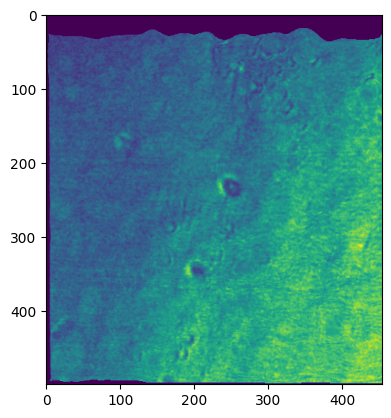

In [39]:
plt.imshow(out['warpedmovout'].numpy())

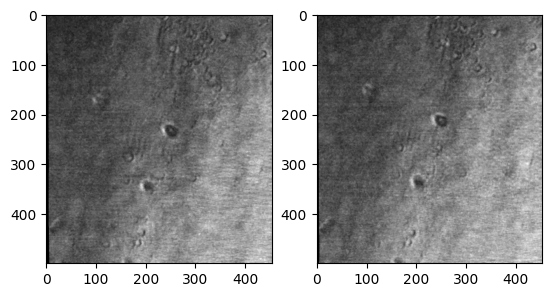

In [37]:
plt.subplot(1,2,1)
plt.imshow(enface_slices[6],cmap='gray')

plt.subplot(1,2,2)
plt.imshow(enface_slices[7],cmap='gray')